In [18]:
import pandas as pd
import spacy
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [25]:
import gensim.downloader as api
import gensim

In [27]:
gensim.downloader

<module 'gensim.downloader' from '/home/grads/g/ganatma/anaconda3/lib/python3.11/site-packages/gensim/downloader.py'>

In [15]:
model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [30]:
words = ["warped", "trace", "rest", "gnarly", "powder", "root", "throne", "shred", "radical", "power", "bent", "lick", "exponent", "bath", "ounce", "twisted"]

word_vectors = np.array([model[word] for word in words if word in model])

In [32]:
word_vectors.shape

(16, 300)

In [33]:
similarity_matrix = cosine_similarity(word_vectors)

for i, word in enumerate(words):
    for j, other_word in enumerate(words):
        print(f"Cosine Similarity between '{word}' and '{other_word}': {similarity_matrix[i][j]:.4f}")

Cosine Similarity between 'warped' and 'warped': 1.0000
Cosine Similarity between 'warped' and 'trace': 0.0686
Cosine Similarity between 'warped' and 'rest': 0.1519
Cosine Similarity between 'warped' and 'gnarly': 0.2726
Cosine Similarity between 'warped' and 'powder': 0.0068
Cosine Similarity between 'warped' and 'root': 0.1217
Cosine Similarity between 'warped' and 'throne': 0.0806
Cosine Similarity between 'warped' and 'shred': 0.2022
Cosine Similarity between 'warped' and 'radical': 0.2689
Cosine Similarity between 'warped' and 'power': 0.0719
Cosine Similarity between 'warped' and 'bent': 0.4435
Cosine Similarity between 'warped' and 'lick': 0.1623
Cosine Similarity between 'warped' and 'exponent': 0.0871
Cosine Similarity between 'warped' and 'bath': 0.0699
Cosine Similarity between 'warped' and 'ounce': 0.0751
Cosine Similarity between 'warped' and 'twisted': 0.5972
Cosine Similarity between 'trace' and 'warped': 0.0686
Cosine Similarity between 'trace' and 'trace': 1.0000
Cosin

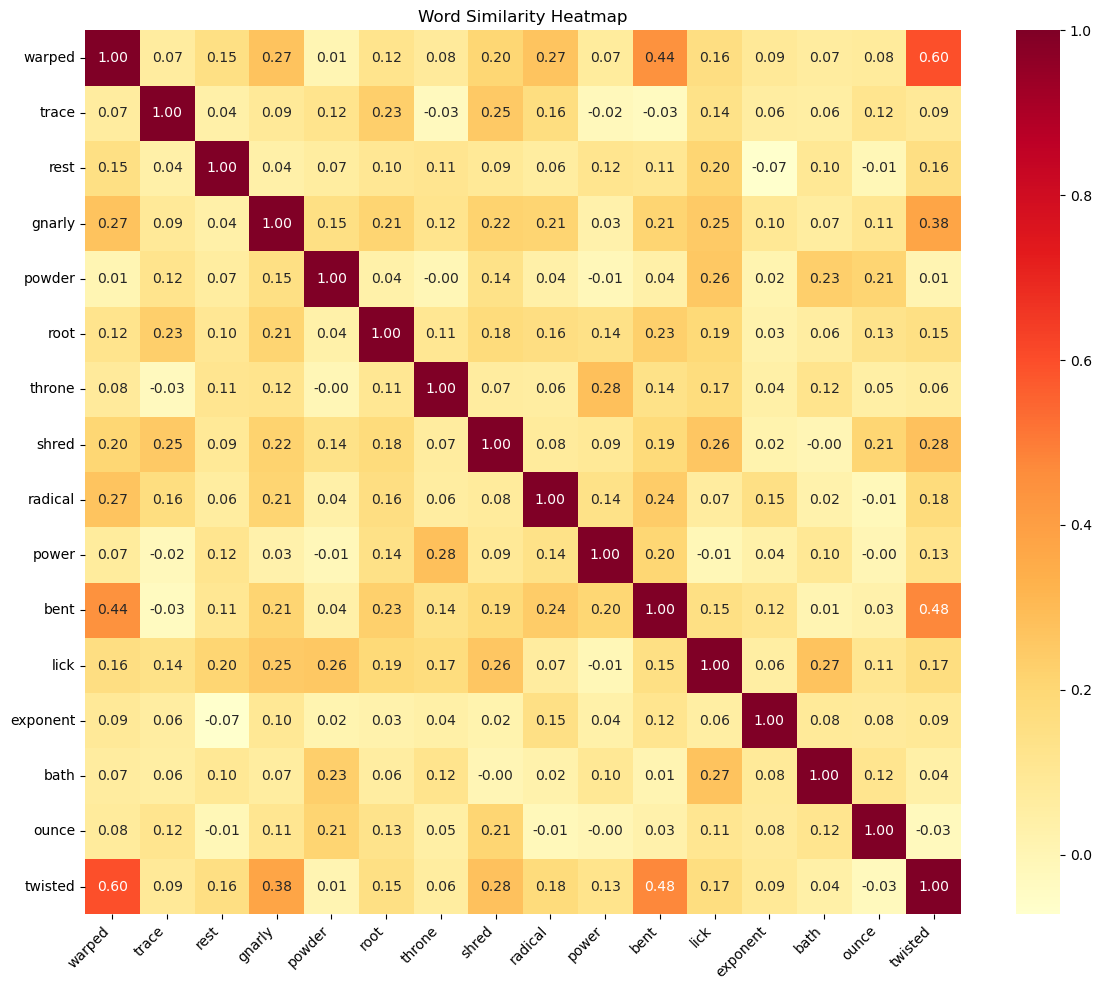

In [34]:
# Plot a heat map of the similarities between wordsimport seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap of the similarity matrix
plt.figure(figsize=(12, 10))
sns.heatmap(similarity_matrix, 
            annot=True,  # Show numbers in cells
            cmap='YlOrRd',  # Yellow-Orange-Red color scheme
            xticklabels=words,
            yticklabels=words,
            fmt='.2f')  # Round to 2 decimal places

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Add title
plt.title('Word Similarity Heatmap')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

In [38]:
def group_similar_words(words, similarity_matrix, similarity_threshold=0.5):
    n = len(words)
    word_groups = []
    used_words = set()
    
    # For each word not yet grouped
    for i in range(n):
        if words[i] in used_words:
            continue
            
        # Start a new group with this word
        current_group = [words[i]]
        used_words.add(words[i])
        
        # Find similar words
        similarities = [(words[j], similarity_matrix[i][j]) 
                       for j in range(n) 
                       if words[j] not in used_words and similarity_matrix[i][j] > similarity_threshold]
        
        # Sort by similarity score
        similarities.sort(key=lambda x: x[1], reverse=True)
        
        # Add the most similar words to the group
        for word, score in similarities:
            if len(current_group) < 4 and word not in used_words:
                current_group.append(word)
                used_words.add(word)
        
        word_groups.append(current_group)
    
    return word_groups

# Group the words
groups = group_similar_words(words, similarity_matrix)

# Print the groups with their likely categories
for i, group in enumerate(groups, 1):
    print(f"\nGroup {i}:")
    print(f"Words: {', '.join(group)}")


Group 1:
Words: warped, twisted

Group 2:
Words: trace

Group 3:
Words: rest

Group 4:
Words: gnarly

Group 5:
Words: powder

Group 6:
Words: root

Group 7:
Words: throne

Group 8:
Words: shred

Group 9:
Words: radical

Group 10:
Words: power

Group 11:
Words: bent

Group 12:
Words: lick

Group 13:
Words: exponent

Group 14:
Words: bath

Group 15:
Words: ounce



Group 1 (Average Similarity: 0.396):
Words: warped, gnarly, bent, twisted

Group 2 (Average Similarity: 0.200):
Words: powder, lick, bath, ounce

Group 3 (Average Similarity: 0.177):
Words: trace, root, shred, radical

Group 4 (Average Similarity: 0.086):
Words: rest, throne, power, exponent


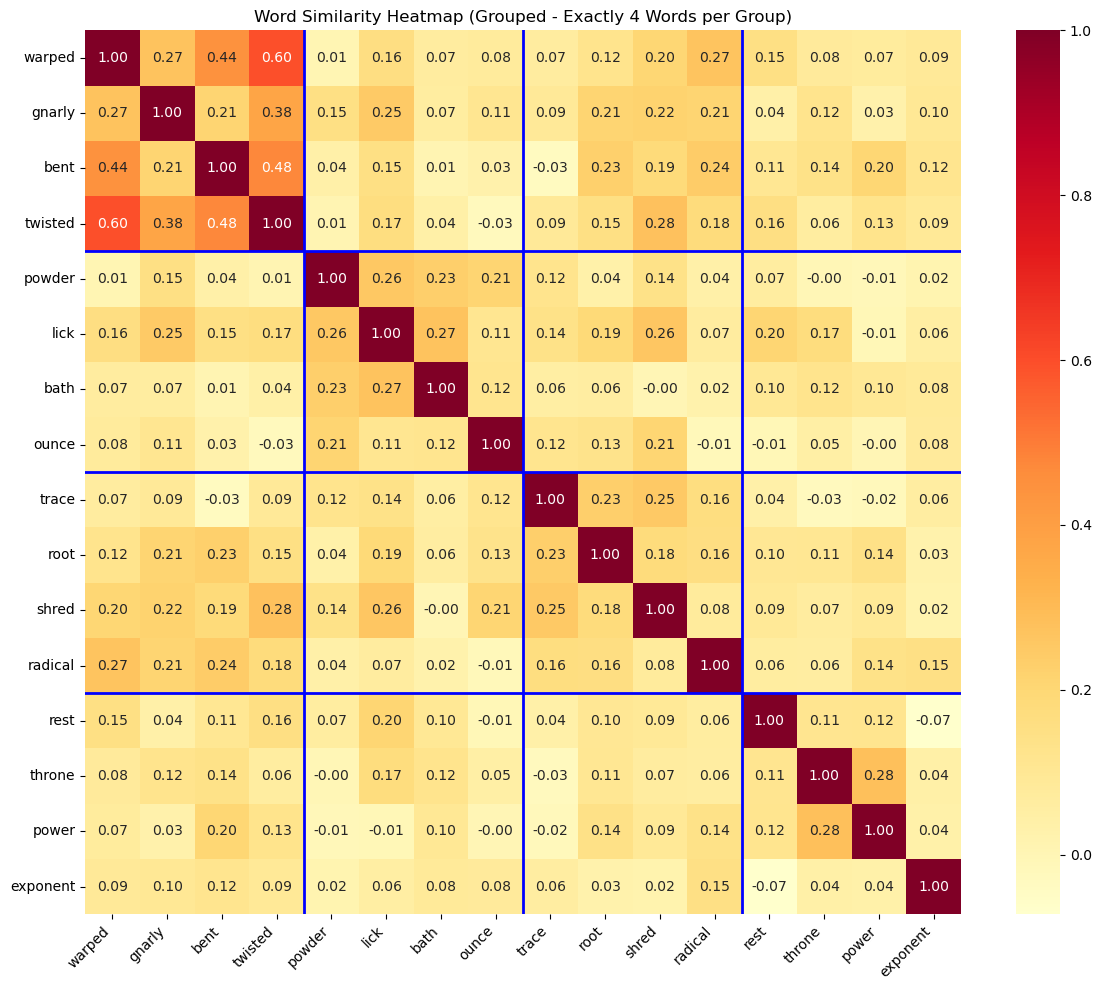

In [41]:
from itertools import combinations
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def group_words_kmeans_fixed_size(words, similarity_matrix, words_per_group=4):
    n = len(words)
    assert n % words_per_group == 0, "Total words must be divisible by words_per_group"
    n_clusters = n // words_per_group
    
    # Convert similarity matrix to distance matrix
    distance_matrix = 1 - similarity_matrix
    
    best_groups = None
    best_score = float('-inf')
    best_labels = None
    
    # Try multiple initializations to find the best grouping
    for _ in range(20):
        kmeans = KMeans(n_clusters=n_clusters, n_init=1, random_state=None)
        labels = kmeans.fit_predict(distance_matrix)
        
        # Check if all clusters have exactly 4 words
        cluster_sizes = [sum(labels == i) for i in range(n_clusters)]
        if not all(size == words_per_group for size in cluster_sizes):
            continue
            
        # Calculate average similarity within groups
        total_score = 0
        for i in range(n_clusters):
            cluster_indices = [j for j, label in enumerate(labels) if label == i]
            similarities = []
            for idx1, idx2 in combinations(cluster_indices, 2):
                similarities.append(similarity_matrix[idx1][idx2])
            total_score += np.mean(similarities) if similarities else 0
            
        if total_score > best_score:
            best_score = total_score
            best_labels = labels
    
    if best_labels is None:
        # Fallback: Use greedy approach if K-means fails to find valid groups
        return group_words_greedy(words, similarity_matrix, words_per_group)
    
    # Organize words into groups
    groups = [[] for _ in range(n_clusters)]
    for word, cluster_idx in zip(words, best_labels):
        groups[cluster_idx].append(word)
    
    # Calculate final group scores
    group_scores = []
    for group in groups:
        group_indices = [words.index(word) for word in group]
        similarities = []
        for i, j in combinations(group_indices, 2):
            similarities.append(similarity_matrix[i][j])
        avg_similarity = np.mean(similarities) if similarities else 0
        group_scores.append(avg_similarity)
    
    # Sort groups by their internal similarity scores
    sorted_groups = [x for _, x in sorted(zip(group_scores, groups), reverse=True)]
    sorted_scores = sorted(group_scores, reverse=True)
    
    return sorted_groups, sorted_scores

def group_words_greedy(words, similarity_matrix, words_per_group=4):
    n = len(words)
    n_groups = n // words_per_group
    groups = []
    remaining_words = set(range(n))
    
    while len(groups) < n_groups:
        best_group = None
        best_score = float('-inf')
        
        # Try all possible combinations of remaining words
        for combo in combinations(remaining_words, words_per_group):
            score = 0
            for i, j in combinations(combo, 2):
                score += similarity_matrix[i][j]
            if score > best_score:
                best_score = score
                best_group = combo
        
        if best_group:
            groups.append([words[i] for i in best_group])
            remaining_words -= set(best_group)
    
    # Calculate group scores
    group_scores = []
    for group in groups:
        indices = [words.index(word) for word in group]
        similarities = []
        for i, j in combinations(indices, 2):
            similarities.append(similarity_matrix[i][j])
        group_scores.append(np.mean(similarities))
    
    return groups, group_scores

# Apply the improved grouping
groups, scores = group_words_kmeans_fixed_size(words, similarity_matrix)

# Print the groups with their similarity scores
for i, (group, score) in enumerate(zip(groups, scores), 1):
    print(f"\nGroup {i} (Average Similarity: {score:.3f}):")
    print(f"Words: {', '.join(group)}")

# Visualize with heatmap
plt.figure(figsize=(12, 10))

# Reorder the similarity matrix based on groups
all_grouped_words = []
for group in groups:
    all_grouped_words.extend(group)

reordered_idx = [words.index(word) for word in all_grouped_words]
reordered_matrix = similarity_matrix[reordered_idx][:, reordered_idx]

# Create heatmap with group boundaries
sns.heatmap(reordered_matrix,
            annot=True,
            cmap='YlOrRd',
            xticklabels=[all_grouped_words[i] for i in range(len(all_grouped_words))],
            yticklabels=[all_grouped_words[i] for i in range(len(all_grouped_words))],
            fmt='.2f')

# Add group boundaries
current_idx = 0
for _ in range(3):  # 3 lines for 4 groups
    current_idx += 4
    plt.axhline(y=current_idx, color='blue', linewidth=2)
    plt.axvline(x=current_idx, color='blue', linewidth=2)

plt.title('Word Similarity Heatmap (Grouped - Exactly 4 Words per Group)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Removing group: warped, gnarly, bent, twisted

New Groups:

Group 1 (Average Similarity: 0.188):
Words: rest, powder, lick, bath

Group 2 (Average Similarity: 0.186):
Words: trace, root, shred, ounce

Group 3 (Average Similarity: 0.117):
Words: throne, radical, power, exponent


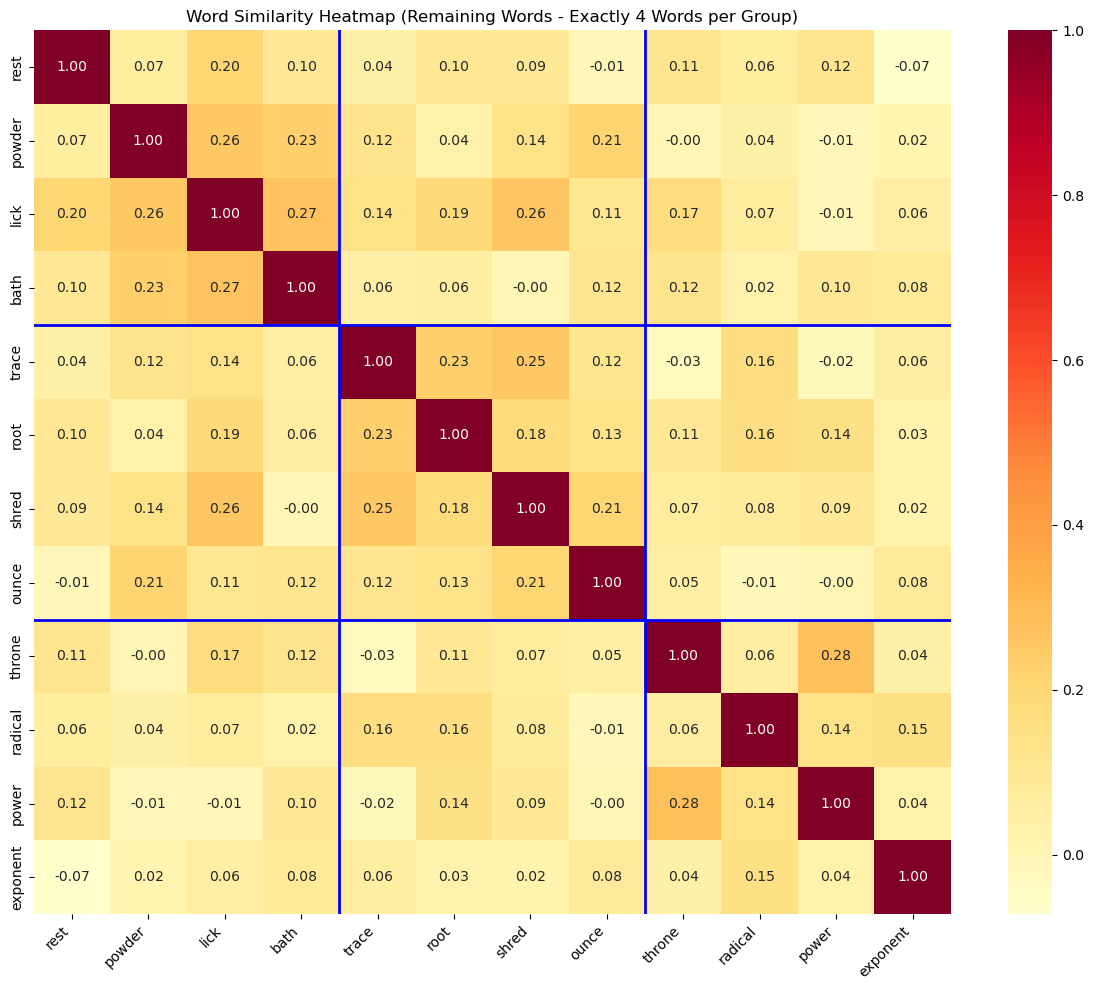

In [42]:
# Get the words from the first group
first_group = groups[0]
print("Removing group:", ', '.join(first_group))

# Create new word list excluding the first group
remaining_words = [word for word in words if word not in first_group]

# Create new similarity matrix for remaining words
remaining_indices = [words.index(word) for word in remaining_words]
new_similarity_matrix = similarity_matrix[remaining_indices][:, remaining_indices]

# Regroup the remaining words
new_groups, new_scores = group_words_kmeans_fixed_size(remaining_words, new_similarity_matrix)

# Print the new groups with their similarity scores
print("\nNew Groups:")
for i, (group, score) in enumerate(zip(new_groups, new_scores), 1):
    print(f"\nGroup {i} (Average Similarity: {score:.3f}):")
    print(f"Words: {', '.join(group)}")

# Visualize new groupings with heatmap
plt.figure(figsize=(12, 10))

# Reorder the similarity matrix based on new groups
all_grouped_words = []
for group in new_groups:
    all_grouped_words.extend(group)

reordered_idx = [remaining_words.index(word) for word in all_grouped_words]
reordered_matrix = new_similarity_matrix[reordered_idx][:, reordered_idx]

# Create heatmap with group boundaries
sns.heatmap(reordered_matrix,
            annot=True,
            cmap='YlOrRd',
            xticklabels=[all_grouped_words[i] for i in range(len(all_grouped_words))],
            yticklabels=[all_grouped_words[i] for i in range(len(all_grouped_words))],
            fmt='.2f')

# Add group boundaries
current_idx = 0
for _ in range(2):  # 2 lines for 3 groups
    current_idx += 4
    plt.axhline(y=current_idx, color='blue', linewidth=2)
    plt.axvline(x=current_idx, color='blue', linewidth=2)

plt.title('Word Similarity Heatmap (Remaining Words - Exactly 4 Words per Group)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [12]:
import spacy

nlp = spacy.load("en_core_web_sm")

def get_similar_words(word):
    word = nlp(word)
    similar_words = []
    for token in nlp.vocab:
        if token.is_lower and token.has_vector and token.vector_norm:
            similarity = word.similarity(token)
            if similarity > 0.6:
                similar_words.append((token.text, similarity))
    return similar_words

print(get_similar_words("happy"))

[]


In [5]:
words=["Whisper",
"Prism",
"Tumble",
"Glisten",
"Radiant",
"Bluster",
"Cascade",
"Drift",
"Clamor",
"Murmur",
"Glare",
"Dapple",
"Gleam",
"Flicker",
"Sparkle",
"Hush"]

In [6]:
df=pd.read_csv("explicitsim353.csv")

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#words = ["radical","power"]
words=["dog","toilet"]
vectorizer = TfidfVectorizer().fit_transform(words)
vectors = vectorizer.toarray()
cosine_sim = cosine_similarity(vectors)
print(cosine_sim)

[[1. 0.]
 [0. 1.]]


In [8]:
import pandas as pd

In [9]:
df=pd.read_csv("explicitsim353.csv")

In [10]:
df

,cs_word_1,cs_word_2,average
0,Arafat,Jackson,2.051282
1,Arafat,peace,2.575000
2,Arafat,terror,3.125000
3,FBI,fingerprint,3.210526
4,FBI,investigation,4.789474
...,...,...,...
348,water,seepage,3.450000
349,weapon,secret,2.378378
350,weather,forecast,5.275000
351,wood,forest,6.710526


In [11]:
df.sort_values(by="average", ascending=False)

,cs_word_1,cs_word_2,average
334,tiger,tiger,9.375000
46,car,automobile,8.600000
196,money,cash,8.512821
195,money,cash,8.128205
189,midday,noon,8.025641
...,...,...,...
149,holy,sex,1.225000
92,delay,racism,1.175000
316,sugar,approach,1.128205
110,drink,ear,1.100000
